In [1]:
import numpy as np
import jax.numpy as jnp
from jax.example_libraries import optimizers
from jax import grad, jit, random
import matplotlib.pyplot as plt
import sys
from einops import rearrange

In [3]:
import tensorflow_datasets as tfds

def load_cifar(animates, inanimates):
    train, test = tfds.as_numpy(tfds.load(
        'cifar10',
        split=['train', 'test'],
        batch_size=-1,
        as_supervised=True,
    ))

    X_train, X_test = train[0], test[0]
    y_train, y_test = train[1], test[1]

    ## TRAIN
    mean = X_train.mean()
    std = X_train.std()
    X_train = (X_train - mean) / std

    y_bin = np.zeros(y_train.shape)

    for k in animates:
        y_bin += 1.0 * (y_train == k)

    for k in inanimates:
        y_bin += -1.0 * (y_train == k)

    inds_where = np.where(y_bin != 0)

    X_train = X_train[inds_where]
    y_train = y_bin[inds_where]

    ## TEST
    mean = X_test.mean()
    std = X_test.std()
    X_test = (X_test - mean) / std

    y_bin = np.zeros(y_test.shape)

    for k in animates:
        y_bin += 1.0 * (y_test == k)

    for k in inanimates:
        y_bin += -1.0 * (y_test == k)

    inds_where = np.where(y_bin != 0)

    X_test = X_test[inds_where]
    y_test = y_bin[inds_where]
    
    return X_train, y_train, X_test, y_test
    

In [5]:
animates = [2,3,4,5]
inanimates = [0,1,8,9]

X_train, y_train, X_test, y_test = load_cifar(animates, inanimates)

In [6]:
X_train_mlp = X_train.reshape(X_train.shape[0], -1) 
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

print(X_train_mlp.shape)
print(X_train.shape)

(40000, 3072)
(40000, 32, 32, 3)


In [7]:
import os
samples = 4000 # of monte carlo draws (neurons) 
S = 16
P = 800
Ptest = 500

eps = random.normal(random.PRNGKey(0), (samples, P+Ptest, 16))

def dmft(samples, C_sqrt, y, P, S, T, eta, lamb, gamma, eps, file):
    h = jnp.einsum('ijkl,sjl->sik', C_sqrt, eps ) 
    h0 = 1.0 * h

    z = random.normal( random.PRNGKey(1), (samples, 16) )
    z0 = 1.0 * z
    Delta = 1.0 * y

    print(h.shape)
    print(Delta.shape)
    print(C_op.shape)

    train_losses = []
    test_losses = []

    def phi_fn(h):
        return h * (h>0.0)

    def dphi_fn(h):
        return 1.0 * (h>0.0)

    phi0 = phi_fn(h0)

    for t in range(T):
        phi = phi_fn(h) # MC x data x space
        dphi = dphi_fn(h)
        g = dphi_fn(h) * z[:,jnp.newaxis,:] 
        # i = mu, j = nu, k = s, l = s' , (sum over nu, s')
        dh =  eta * (gamma * jnp.einsum('ijkl, njl -> nik', C_op[:, :P, :, :], Delta[jnp.newaxis,:P,jnp.newaxis] * g[:, :P, :] ) / P - lamb * h)
        dz = eta * (gamma * jnp.mean( Delta[jnp.newaxis, :P, jnp.newaxis] * phi[:, :P, :] , axis = 1 ) - lamb * z)
        Delta = y - 1.0/gamma * jnp.mean( phi * z[:,jnp.newaxis,:], axis = 0 ).sum(axis=1)
        Delta += 1.0/gamma * jnp.mean( phi_fn(h0) * z0[:,jnp.newaxis,:], axis = 0 ).sum(axis=1)
        h += dh
        z += dz

        train_losses += [ 0.5 * jnp.mean(Delta[:P] **2) ]
        test_losses += [jnp.mean(Delta[P:] ** 2)] 

        train_loss = train_losses[-1]
        test_loss = test_losses[-1]
        
        sys.stdout.write(f'\r Iteration {t + 1}/{T}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}')

        #print(f"Iteration {t + 1}/{T}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
                
        if train_loss < 1e-3:
            print("Stopping early as train loss < 1e-3")
            with open(file, 'a') as f:
                f.write(f"{P} {lamb:.6f} {eta: .6f} {gamma:.6f} {train_loss:.6f} {test_loss:.6f}\n")
            break
        elif t+1 == T:
            with open(file, 'a') as f:
                f.write(f"{P} {lamb:.6f} {eta: .6f} {gamma:.6f} {train_loss:.6f} {test_loss:.6f}\n")
    


    return train_losses, test_losses, y, phi, phi0, h, z

In [8]:
P = 800
Ptest = 500

X_train, y_train = X_train[:P], y_train[:P]
X_test, y_test = X_test[:Ptest], y_test[:Ptest]

X = jnp.array(jnp.vstack([X_train, X_test]))
y = jnp.array(jnp.concatenate([y_train, y_test]))

X_tensor = rearrange(X, 's (a p1) (b p2) c -> s a b p1 p2 c', p1 = 8, p2=8)
print(X_tensor.shape)

C = jnp.einsum('s a b p k c, m d f p k c -> s m a b d f', X_tensor, X_tensor) / (X_tensor.shape[3] * X_tensor.shape[4]  * X_tensor.shape[5])  # should give P x P x L x L x H x H
print(C.shape)

C_flat = rearrange(C, 'a b c d e f -> (a c d) (b e f)')
print(C_flat.shape)

s, v = jnp.linalg.eigh(C_flat)

s = (s > 0.0) * s
s_sqrt = jnp.sqrt(s)
C_sqrt_flat = v @ jnp.diag(s_sqrt) @ v.T

C_sqrt = rearrange(C_sqrt_flat, '(a c) (b d) -> a b c d', c = 16, d = 16)
C_op = rearrange(C_flat, '(a c) (b d) -> a b c d', c = 16, d = 16)

C_op_back = rearrange(C_op, 'a b (c d) (e f) -> a b c d e f', d = 4, f = 4)

print(jnp.mean((C_op_back-C)**2) / jnp.mean(C**2))

(1300, 4, 4, 8, 8, 3)
(1300, 1300, 4, 4, 4, 4)
(20800, 20800)
0.0


In [9]:
T = 20000
eta = 3e-2
lamb = 1e-2
gamma = 2.0
train_losses, test_losses, y, phi, phi0, h, z = dmft(samples, C_sqrt, y, P, S, T, eta, lamb, gamma,eps, f'cnn_P{P}.txt')

(4000, 1300, 16)
(1300,)
(1300, 1300, 16, 16)
 Iteration 20000/20000: Train Loss = 0.083614, Test Loss = 0.462299

In [12]:
# Train the 2 layer MLP with weight decay
#dmft
def sqrt_svd(Sigma, eps=1e-4):
    s, v = jnp.linalg.eigh(Sigma + eps*jnp.eye(Sigma.shape[0]))
    s = s * (s > 0.0)  # Ensure non-negative eigenvalues
    return v @ jnp.diag(jnp.sqrt(s)) @ v.T

def solve_dynamics_reg(Kx, y, P, gamma, lamb, file, sigma=1.0, num_iter=30000, samples=4000, lr=1e-3):
    Kx_root = sqrt_svd(Kx)  # Compute the square root of Kx, assuming sqrt_svd is defined
    h = sigma * random.normal(random.PRNGKey(0), (samples, int(y.shape[0]))) @ Kx_root
    z = sigma * random.normal(random.PRNGKey(1), (samples,))

    # Initial Delta and compute initial phi and Phi0
    #Delta = y
    phi = h * (h > 0.0)
    Phi0 = phi.T @ phi / samples
    f0 = 1.0/gamma * jnp.einsum('ij,i->j', phi, z) / samples
    Delta0 = 1.0 * y - 1/gamma * phi.T @ z / samples + f0

    train_losses = []
    test_losses = []

    for n in range(num_iter):
        phi = h * (h > 0.0)
        g = (h > 0.0) * z[:, jnp.newaxis]
        Delta = 1.0 * y - 1/gamma * phi.T @ z / samples + f0

        h += lr * (gamma * jnp.einsum('ij,kj->ik', g[:, :P] * Delta[jnp.newaxis, :P], Kx[:, :P]) - lamb * h)
        z += lr * (gamma * jnp.einsum('ij,j->i', phi[:, :P], Delta[:P]) - lamb * z)

        # Compute and store train and test losses
        train_loss = 0.5 * jnp.mean(Delta[:P] ** 2) 
        test_loss = jnp.mean(Delta[P:] ** 2)   
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        sys.stdout.write(f'\r Iteration {n + 1}/{num_iter}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}')

        #print(f"Iteration {n + 1}/{num_iter}: Train Loss = {train_loss:.6f}  Test Loss = {test_loss:.6f}")
        
        if train_loss < 1e-5:
            print("\r Stopping early as train loss < 1e-5 ")
            with open(file, 'a') as f:
                f.write(f"{P} {lamb:.6f} {gamma:.6f} {train_loss:.6f} {test_loss:.6f}\n")
            break
        elif n+1 == num_iter:
            with open(file, 'a') as f:
                f.write(f"{P} {lamb:.6f} {gamma:.6f} {train_loss:.6f} {test_loss:.6f}\n")
    
    # Final kernel matrix
    Phi = phi.T @ phi / samples
    

    return train_losses, test_losses, y, Phi, Phi0, h, z

In [10]:
X_train, y_train = X_train_mlp[:P], y_train[:P]
X_test, y_test = X_test_mlp[:Ptest], y_test[:Ptest]

X = jnp.array(jnp.vstack([X_train, X_test]))
y = jnp.array(jnp.concatenate([y_train, y_test]))

D = X_train.shape[1]
Kx = (1 / D) * X @ X.T
Kx_root = sqrt_svd(Kx)

In [12]:
train,test, y, Phi, Phi0, h, z = solve_dynamics_reg(Kx, y, P, gamma, lamb, f'mlp_P800.txt', lr=1e-4)

 Stopping early as train loss < 1e-30.001000, Test Loss = 0.576319


In [13]:
P_values = np.arange(1000, 1050, 50)
Ptest = 500
T = 200000
samples = 10000
eta = 1e-3
lamb = 1e-2
gamma = 1.0

animates = [2,3,4,5]
inanimates = [0,1,8,9]

X_train, y_train, X_test, y_test = load_cifar(animates, inanimates)

for P in P_values: 
    file_mlp = f'mlp_gamma1.txt'
    
    #train MLP
    X_train_mlp = X_train.reshape(X_train.shape[0], -1) 
    X_test_mlp = X_test.reshape(X_test.shape[0], -1)
    X_train_mlp, y_train_mlp = X_train_mlp[:P], y_train[:P]
    X_test_mlp, y_test_mlp = X_test_mlp[:Ptest], y_test[:Ptest]

    X_mlp = jnp.array(jnp.vstack([X_train_mlp, X_test_mlp]))
    y_mlp = jnp.concatenate([y_train_mlp, y_test_mlp])
    #print(y_mlp.shape[0])
    D = X_mlp.shape[1]
    Kx = (1 / D) * X_mlp @ X_mlp.T
    Kx_root = sqrt_svd(Kx)
    
    train, test, y, Phi, Phi0, h, z = solve_dynamics_reg(Kx, y_mlp, P, gamma, lamb, file_mlp, lr=eta)
    

 Stopping early as train loss < 1e-5 .000010, Test Loss = 0.568273


In [14]:
T = 200000
eta = 1e-3
lamb = 1e-2
gamma = 1.0

animates = [2,3,4,5]
inanimates = [0,1,8,9]


X_train, y_train, X_test, y_test = load_cifar(animates, inanimates)
P_values = np.arange(1000, 1050, 50)
for P in P_values:
    file_cnn = f'cnn_gamma1.txt'
    X_train_cnn, y_train_cnn = X_train[:P], y_train[:P]
    X_test_cnn, y_test_cnn = X_test[:Ptest], y_test[:Ptest]

    X_cnn = jnp.array(jnp.vstack([X_train_cnn, X_test_cnn]))
    y_cnn = jnp.array(jnp.concatenate([y_train_cnn, y_test_cnn]))

    X_tensor = rearrange(X_cnn, 's (a p1) (b p2) c -> s a b p1 p2 c', p1 = 8, p2=8)
    #print(X_tensor.shape)

    C = jnp.einsum('s a b p k c, m d f p k c -> s m a b d f', X_tensor, X_tensor) / (X_tensor.shape[3] * X_tensor.shape[4]  * X_tensor.shape[5])  # should give P x P x L x L x H x H
    #print(C.shape)

    C_flat = rearrange(C, 'a b c d e f -> (a c d) (b e f)')
    #print(C_flat.shape)

    s, v = jnp.linalg.eigh(C_flat)

    s = (s > 0.0) * s
    s_sqrt = jnp.sqrt(s)
    C_sqrt_flat = v @ jnp.diag(s_sqrt) @ v.T

    C_sqrt = rearrange(C_sqrt_flat, '(a c) (b d) -> a b c d', c = 16, d = 16)
    C_op = rearrange(C_flat, '(a c) (b d) -> a b c d', c = 16, d = 16)

    C_op_back = rearrange(C_op, 'a b (c d) (e f) -> a b c d e f', d = 4, f = 4)

    #print(jnp.mean((C_op_back-C)**2) / jnp.mean(C**2))
    
    eps = random.normal(random.PRNGKey(0), (samples, P+Ptest, 16))
    train_losses, test_losses, y, phi, phi0, h, z = dmft(samples, C_sqrt, y_cnn, P, S, T, eta, lamb, gamma, eps, file_cnn)

(10000, 1500, 16)
(1500,)
(1500, 1500, 16, 16)
 Iteration 200000/200000: Train Loss = 0.188255, Test Loss = 0.460947

In [15]:
# train GF

def NN_func(params, X, gamma):
    W, z = params
    N = z.shape[0]
    D = X.shape[0]  # X is assumed to have shape (D, num_samples)
    h = W @ X / jnp.sqrt(D)
    phi = h * (h > 0.0)
    f = phi.T @ z / N / gamma
    return f

def NN_train(X_train, y_train, X_test, y_test, gamma, lamb, file, N=5000, lr=1e-3, steps=30000):

    X_train = X_train.T
    X_test = X_test.T
    D = X_train.shape[0]  # D is now the feature dimension

    # Initialize parameters
    W = random.normal(random.PRNGKey(0), (N, D))
    z = random.normal(random.PRNGKey(1), (N,))

    # Compute initial phi and Phi0 for both training and test sets
    X = jnp.hstack([X_train, X_test])
    h = W @ X / jnp.sqrt(D)
    phi = h * (h > 0.0)
    Phi0 = phi.T @ phi / N

    # Define loss function and its gradient
    loss = lambda params, X, y: 0.5 * jnp.sum((NN_func(params, X, gamma) - y) ** 2)
    grad_loss = grad(loss)

    params = [W, z]
    train_losses = []
    test_losses = []

    # Training loop
    for n in range(steps):
        # Compute current train and test losses
        train_loss = 0.5 * jnp.mean((NN_func(params, X_train, gamma) - y_train) ** 2)
        test_loss = jnp.mean((NN_func(params, X_test, gamma) - y_test) ** 2)

        #print(f"Iteration {n + 1}/{steps}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")
        sys.stdout.write(f'\r Iteration {n + 1}/{steps}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}')

        # Append losses to respective lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Compute gradients
        grads = grad_loss(params, X_train, y_train)

        # Update parameters with gradient descent (training data only)
        W += -lr * N * gamma**2 * grads[0] - lr * lamb * W
        z += -lr * N * gamma**2 * grads[1] - lr * lamb * z
        params = [W, z]
        

        if train_loss < 1e-5:
            print("\r Stopping early as train loss < 1e-5 ")
            with open(file, 'a') as f:
                f.write(f"{P} {lamb:.6f} {gamma:.6f} {train_loss:.6f} {test_loss:.6f}\n")
            break
        elif n+1 == steps:
            with open(file, 'a') as f:
                f.write(f"{P} {lamb:.6f} {gamma:.6f} {train_loss:.6f} {test_loss:.6f}\n")    
        

    # Compute final phi and Phi for both training and test sets
    h = W @ X / jnp.sqrt(D)
    phi = h * (h > 0.0)
    Phi = phi.T @ phi / N

    return train_losses, test_losses, Phi, Phi0, h, z

In [16]:
P_values = np.arange(1000, 1050, 50)
Ptest = 500
T = 200000
samples = 10000
eta = 1e-3
lamb = 1e-2
gamma = 1.0

animates = [2,3,4,5]
inanimates = [0,1,8,9]

X_train, y_train, X_test, y_test = load_cifar(animates, inanimates)

for P in P_values: 
    file_mlp = f'mlp_exp_gamma1.txt'
    
    #train MLP
    X_train_mlp = X_train.reshape(X_train.shape[0], -1) 
    X_test_mlp = X_test.reshape(X_test.shape[0], -1)
    X_train_mlp, y_train_mlp = X_train_mlp[:P], y_train[:P]
    X_test_mlp, y_test_mlp = X_test_mlp[:Ptest], y_test[:Ptest]

    X_mlp = jnp.array(jnp.vstack([X_train_mlp, X_test_mlp]))
    y_mlp = jnp.concatenate([y_train_mlp, y_test_mlp])
    #print(y_mlp.shape[0])
    D = X_mlp.shape[1]
    #Kx = (1 / D) * X_mlp @ X_mlp.T
    #Kx_root = sqrt_svd(Kx)
    
    train_mlp, test_mlp, Phi, Phi0, h, z = NN_train(X_train_mlp, y_train_mlp, X_test_mlp, y_test_mlp, gamma, lamb, file_mlp, N=5000, lr=eta, steps=T)

 Stopping early as train loss < 1e-5 0.000010, Test Loss = 0.570012


In [17]:
from flax import linen as nn

class Conv(nn.Module):
  """A simple ResNet model"""
  
  width: int

  @nn.compact
  def __call__(self, x, train = True):
    kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
    N = self.width
    D = 3
    k_size = 8
    x = nn.Conv(features = N, kernel_init = kif, kernel_size = (k_size,k_size), strides=k_size, use_bias=False, padding = 'VALID')(x) / jnp.sqrt(D * k_size**2)
    h = x
    phi = nn.relu(x)
    # at this point we have a   

    x = phi.reshape((phi.shape[0], -1))  # flatten
    x = nn.Dense(features = 1, use_bias = False, kernel_init = kif)(x) / N  # for mean field scaling
    return x   
    
class Conv_hidden(nn.Module):
  """A simple ResNet model"""
  
  width: int

  @nn.compact
  def __call__(self, x, train = True):
    kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
    N = self.width
    D = 3
    k_size = 8
    x = nn.Conv(features = N, kernel_init = kif, kernel_size = (k_size,k_size), strides=k_size, use_bias=False, padding = 'VALID')(x) / jnp.sqrt(D * k_size**2)
    h = x
    x = nn.relu(x)
    phi = x
    # at this point we have a 
    #x = nn.avg_pool(x, window_shape=(4,4), strides = (4,4)) # 4 x 4 -> 1 x 1
  

    x = x.reshape((x.shape[0], -1))  # flatten
    print("flattened shape")
    print(x.shape)
    x = nn.Dense(features = 1, use_bias = False, kernel_init = kif)(x) / N  # for mean field scaling
    return x, h, phi
    #return x

In [18]:
# Gradient flow with wd
import os
import jax
import optax
N = 1024
cnn = Conv(width = N)

key = jax.random.PRNGKey(0)

def train_CNN(N, X, y, T, lr, lamb, gamma, file_nn):
    params = cnn.init(key, jnp.ones((10,32,32,3)))['params']


    opt_init, opt_update, get_params = optimizers.sgd(lr)
    opt_state = opt_init(params)
    #print(res.apply({'params':params}, X[0:25]).shape)
    shift_fn = jax.jit(lambda p, x: (cnn.apply({'params':p}, x) - cnn.apply({'params':params}, x)) / gamma)
    loss_fn = jax.jit(lambda params, Xb, yb: optax.losses.squared_error(predictions=shift_fn(params, Xb), targets=yb).mean())
    grad_fn = jax.jit(jax.grad(loss_fn))

    train_losses_nn = []
    test_losses_nn = []
    for t in range(T):

        train_losses_nn += [0.5 * loss_fn(get_params(opt_state), X[:P], y[:P, jnp.newaxis]) ]
        test_losses_nn += [ loss_fn(get_params(opt_state), X[P:], y[P:, jnp.newaxis]) ]

        grads = grad_fn(get_params(opt_state), X[:P], y[:P, jnp.newaxis])
        params = get_params(opt_state)
        grads = jax.tree_util.tree_map(lambda g, p:  (0.5 * N * gamma**2 * g) + (lamb * p), grads, params)

        opt_state = opt_update(t, grads, opt_state)
        train_loss_nn = train_losses_nn[-1]
        test_loss_nn = test_losses_nn[-1]
        sys.stdout.write(f"\r Iteration {t + 1}/{T}: Train Loss = {train_loss_nn:.6f}, Test Loss = {test_loss_nn:.6f}")

        if train_loss_nn < 1e-3:
            print("\r Stopping early as train loss < 1e-3")
            with open(file_nn, 'a') as f:
                f.write(f"{P} {lamb:.6f} {lr: .6f} {gamma:.6f} {train_loss_nn:.6f} {test_loss_nn:.6f}\n")
            break
        elif t+1 == T:
            with open(file_nn, 'a') as f:
                f.write(f"{P} {lamb:.6f} {lr: .6f} {gamma:.6f} {train_loss_nn:.6f} {test_loss_nn:.6f}\n")
    cnn_hid = Conv_hidden(width = N)
    _, h, phi_expt = cnn_hid.apply({'params':params},X)
    return train_losses_nn, test_losses_nn, phi_expt

In [19]:
T = 200000
eta = 1e-3
lr = eta
lamb = 1e-2
gamma = 1.0

animates = [2,3,4,5]
inanimates = [0,1,8,9]

X_train, y_train, X_test, y_test = load_cifar(animates, inanimates)
P_values = np.arange(1000, 1050, 50)
for P in P_values:
    file_nn = f'cnn_exp_gamma1.txt'
    X_train_cnn, y_train_cnn = X_train[:P], y_train[:P]
    X_test_cnn, y_test_cnn = X_test[:Ptest], y_test[:Ptest]

    X_cnn = jnp.array(jnp.vstack([X_train_cnn, X_test_cnn]))
    y_cnn = jnp.array(jnp.concatenate([y_train_cnn, y_test_cnn]))

    X_tensor = rearrange(X_cnn, 's (a p1) (b p2) c -> s a b p1 p2 c', p1 = 8, p2=8)
    #print(X_tensor.shape)

    C = jnp.einsum('s a b p k c, m d f p k c -> s m a b d f', X_tensor, X_tensor) / (X_tensor.shape[3] * X_tensor.shape[4]  * X_tensor.shape[5])  # should give P x P x L x L x H x H
    #print(C.shape)

    C_flat = rearrange(C, 'a b c d e f -> (a c d) (b e f)')
    #print(C_flat.shape)

    s, v = jnp.linalg.eigh(C_flat)

    s = (s > 0.0) * s
    s_sqrt = jnp.sqrt(s)
    C_sqrt_flat = v @ jnp.diag(s_sqrt) @ v.T

    C_sqrt = rearrange(C_sqrt_flat, '(a c) (b d) -> a b c d', c = 16, d = 16)
    C_op = rearrange(C_flat, '(a c) (b d) -> a b c d', c = 16, d = 16)

    C_op_back = rearrange(C_op, 'a b (c d) (e f) -> a b c d e f', d = 4, f = 4)

    #print(jnp.mean((C_op_back-C)**2) / jnp.mean(C**2))
    
    train_losses_nn, test_losses_nn, phi_exp = train_CNN(N, X_cnn, y_cnn, T, lr, lamb, gamma, file_nn)

 Iteration 200000/200000: Train Loss = 0.188071, Test Loss = 0.463989flattened shape
(1500, 16384)


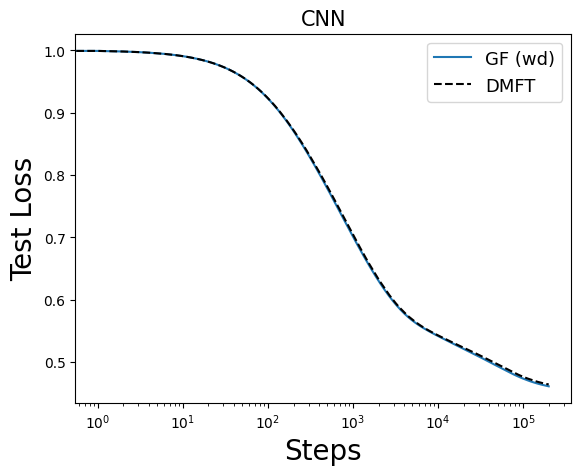

In [20]:
plt.semilogx(test_losses, linewidth = 1.5, label = 'GF (wd)')
plt.plot(test_losses_nn, linestyle = '--', color = 'black', label = 'DMFT')
plt.title('CNN', fontsize = 15)

plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Test Loss', fontsize = 20)
plt.legend(fontsize= 13)